## DV1597 Assignment 2
Group 9


***
Viktor Fransson

vifr22@student.bth.se

***

Tobias Gustafsson

togu22@student.bth.se
***

#### Initialize

In [449]:
# Import packages
import pandas as pd
import matplotlib.pyplot as mpl # Version 3.8.4
import seaborn as sb
import numpy as np
import scipy.stats as stats
import geopandas as gpd
from IPython.display import display, HTML, display_html
from shapely.geometry import Polygon
import fsspec
import scipy

In [450]:
# Ignore future and deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [451]:
# Load datasets
PATH = 'Assignment 2_datasets/'
df_daily_original = pd.read_csv(PATH + '1.COVID-19_daily_number_of_new_cases_and_deaths.csv')
df_vaccination_original = pd.read_csv(PATH + '2.COVID-19_vaccination.csv')
df_admissions_original = pd.read_csv(PATH + '3.COVID-19_hospital_and_ICU_admission_rates.csv')

***


#### Data munging

Store country data in a dictionary. For fetching country name and population from geoID.

In [452]:
# Load countries, drop unwanted (for this) columns.
df_pop = df_daily_original.copy().groupby('countriesAndTerritories').first().reset_index()
df_pop.drop(['dateRep', 'day','month', 'year', 'cases','deaths','countryterritoryCode', 'continentExp'], axis=1, inplace=True)

pop_dict = {}
name_dict = {}

# Extract population and name data and store in dictionary
for i in range(len(df_pop)):
    geo_id = df_pop.iloc[i]['geoId']
    country = df_pop.iloc[i]['countriesAndTerritories']
    pop_data = df_pop.iloc[i]['popData2020']
    pop_dict[geo_id] = pop_data
    pop_dict[country] = pop_data
    name_dict[geo_id] = country

##### Munging 1. Daily cases and deaths

In [453]:
df_daily = df_daily_original.copy()

# Add a DateTime Column
df_daily['Time'] = pd.to_datetime(df_daily['dateRep'], format='%d/%m/%Y')

# Rename, sort, and order selected columns
df_daily = df_daily.rename(columns={'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories':'Country', 'popData2020':'Population'})
df_daily = df_daily[['Country', 'Time', 'Cases', 'Deaths', 'Population']]
df_daily = df_daily.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_daily)

,Country,Time,Cases,Deaths,Population
0,Austria,2020-02-26,1.0,0.0,8901064
1,Austria,2020-02-27,2.0,0.0,8901064
2,Austria,2020-02-28,4.0,0.0,8901064
3,Austria,2020-02-29,1.0,0.0,8901064
4,Austria,2020-03-01,4.0,0.0,8901064
...,...,...,...,...,...
28724,Sweden,2022-10-08,400.0,0.0,10327589
28725,Sweden,2022-10-09,225.0,2.0,10327589
28726,Sweden,2022-10-10,482.0,1.0,10327589
28727,Sweden,2022-10-11,743.0,0.0,10327589


##### Munging of 2. Vaccine data

Replace NaN-values in numerical columns with 0. 

Some countries have reported data for each region, we remove the region data since we are not interested in regional differences.



In [454]:
df_vaccination = df_vaccination_original.copy()

# Replace NaN with zero for selected columns
num_cols = ['NumberDosesReceived','NumberDosesExported','FirstDose','FirstDoseRefused','SecondDose','DoseAdditional1',
            'DoseAdditional2','DoseAdditional3','DoseAdditional4','DoseAdditional5','UnknownDose']
for column in num_cols:
    df_vaccination[column] = df_vaccination[column].fillna(0)

# Remove regional data
df_vaccination = df_vaccination.drop(df_vaccination[df_vaccination['Region'] != df_vaccination['ReportingCountry']].index)

Countries have reported the data in slightly different ways. We add two age groups for the countries that does not already have them: Age<18 and 1_Age60+.

In [455]:
# Under 18 and 60+ target groups
u18_list = ['Age0_4', 'Age5_9', 'Age10_14', 'Age15_17']
o60_list = ['Age60_69', 'Age70_79', 'Age80+']
groups = (('Age<18',u18_list), ('1_Age60+',o60_list))

# Create a group of all countries
df_country = df_vaccination.groupby('ReportingCountry')

# Create a list for adding new rows
all_rows = [df_vaccination]

# Iterate over each country
for country in df_country:
    # Get data for the country, find all the targetgroups
    dfc = df_vaccination.loc[df_vaccination['ReportingCountry'] == country[0]]
    df_temp = dfc.groupby('TargetGroup').first().reset_index()
    
    for g in groups:
        if g[0] not in df_temp['TargetGroup'].values:
            # Remove all TargetGroups of wrong type, sum the rest
            dfc_age = dfc[dfc['TargetGroup'].isin(g[1])].reset_index(drop=True)
            dfc_age_group = dfc_age.groupby(['YearWeekISO','ReportingCountry','NumberDosesReceived','NumberDosesExported','Region','Vaccine','Population']).sum().reset_index()

            # Calculate denominator for Age-group
            denominator = dfc_age_group.groupby('TargetGroup').first().sum().loc['Denominator']
            dfc_age_group = dfc_age_group.assign(Denominator=denominator)
            
            # Rename TargetGroup, add to list
            dfc_age_group = dfc_age_group.assign(TargetGroup=g[0])
            all_rows.append(dfc_age_group)
    
# Add values to df_vaccination
df_vaccination = pd.concat(all_rows, ignore_index=True)


Change some columns from type float to int

In [456]:
# Columns to change from type float to int
float_columns = ['FirstDoseRefused','NumberDosesReceived','NumberDosesExported']
for f in float_columns:
    df_vaccination[f] = df_vaccination[f].astype(int)

In [457]:
# Add time column 
df_vaccination['Time'] = pd.to_datetime(df_vaccination['YearWeekISO'] + '-1', format='%G-W%V-%u')

# Summarize additional doses to one column
df_vaccination['AdditionalDoses'] = df_vaccination['DoseAdditional1'] + df_vaccination['DoseAdditional2']+df_vaccination['DoseAdditional3']+df_vaccination['DoseAdditional4']+df_vaccination['DoseAdditional5']
df_vaccination['TotalDoses'] = df_vaccination['FirstDose']+df_vaccination['SecondDose']+df_vaccination['AdditionalDoses']+df_vaccination['UnknownDose']

# Add Country name column
df_vaccination['Country'] = df_vaccination['ReportingCountry'].map(name_dict)

# Select and order columns
df_vaccination = df_vaccination[['Country','Time', 'TargetGroup','TotalDoses', 'FirstDose', 'SecondDose', 'AdditionalDoses', 'UnknownDose', 'Vaccine', 'Population']]

# Sort by Country name and Time
df_vaccination = df_vaccination.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_vaccination)

,Country,Time,TargetGroup,TotalDoses,FirstDose,SecondDose,AdditionalDoses,UnknownDose,Vaccine,Population
0,Austria,2020-12-28,Age50_59,0,0,0,0,0,JANSS,8901064
1,Austria,2020-12-28,Age18_24,0,0,0,0,0,JANSS,8901064
2,Austria,2020-12-28,Age<18,0,0,0,0,0,COMBA.1,8901064
3,Austria,2020-12-28,Age60_69,0,0,0,0,0,COMBA.1,8901064
4,Austria,2020-12-28,Age25_49,2,2,0,0,0,COMBA.1,8901064
...,...,...,...,...,...,...,...,...,...,...
208934,Sweden,2023-04-10,Age<18,0,0,0,0,0,NVXD,10452326
208935,Sweden,2023-04-10,1_Age60+,0,0,0,0,0,AZ,10452326
208936,Sweden,2023-04-10,1_Age60+,513,0,0,513,0,COM,10452326
208937,Sweden,2023-04-10,1_Age60+,0,0,0,0,0,MOD,10452326


##### Munging of 3. hospital and ICU data

Munging of hospital data

In [458]:
df_admissions = df_admissions_original.copy()

# Add dateTime column
df_admissions['Time'] = pd.to_datetime(df_admissions['date'])
df_admissions = df_admissions.rename(columns={'country': 'Country'})

Daily hospital occupancy

In [459]:
# Slice for indicator == Daily hospital occupancy
df_hosp_daily = df_admissions[df_admissions['indicator'] == 'Daily hospital occupancy'].copy()
df_hosp_daily = df_hosp_daily.rename(columns={'value':'Daily hospital occupancy'})

# Set population data, calculate daily hospital occupancy per 100k
df_hosp_daily['Population'] = df_hosp_daily['Country'].map(pop_dict)
df_hosp_daily['Daily hospital occupancy per 100k'] = df_hosp_daily['Daily hospital occupancy']/(df_hosp_daily['Population']/100000)

# Select and order columns
df_hosp_daily = df_hosp_daily[['Country','Time','Daily hospital occupancy', 'Daily hospital occupancy per 100k']]

# Sort by Country name and Time
df_hosp_daily = df_hosp_daily.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_hosp_daily)

,Country,Time,Daily hospital occupancy,Daily hospital occupancy per 100k
0,Austria,2020-04-01,856.0,9.616828
1,Austria,2020-04-02,823.0,9.246086
2,Austria,2020-04-03,829.0,9.313493
3,Austria,2020-04-04,826.0,9.279789
4,Austria,2020-04-05,712.0,7.999044
...,...,...,...,...
10979,Spain,2023-03-03,1827.0,3.859918
10980,Spain,2023-03-10,2006.0,4.238093
10981,Spain,2023-03-17,2145.0,4.531759
10982,Spain,2023-03-24,2014.0,4.254994


Weekly new hospital admissions per 100k

In [460]:
# Slice for indicator == Weekly new hospital admissions per 100k
df_hosp_weekly = df_admissions[df_admissions['indicator'] == 'Weekly new hospital admissions per 100k'].copy()
df_hosp_weekly = df_hosp_weekly.rename(columns={'value':'Weekly new hospital admissions per 100k'})

# Select and order columns
df_hosp_weekly = df_hosp_weekly[['Country','Time','Weekly new hospital admissions per 100k']]

# Sort by Country name and Time
df_hosp_weekly = df_hosp_weekly.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_hosp_weekly)

,Country,Time,Weekly new hospital admissions per 100k
0,Belgium,2020-03-15,13.118002
1,Belgium,2020-03-22,12.902812
2,Belgium,2020-03-29,30.118037
3,Belgium,2020-04-05,30.737785
4,Belgium,2020-04-12,24.359544
...,...,...,...
2911,Spain,2023-03-26,2.439236
2912,Spain,2023-04-02,2.375988
2913,Spain,2023-04-09,2.264252
2914,Spain,2023-04-16,2.719632


Weekly ICU admissions per 100k

In [461]:
# Slice for indicator == Weekly ICU 
df_icu_weekly = df_admissions[df_admissions['indicator'] == 'Weekly new ICU admissions per 100k'].copy()
df_icu_weekly = df_icu_weekly.rename(columns={'value':'Weekly new ICU admissions per 100k'})

# # Select and order columns
df_icu_weekly = df_icu_weekly[['Country','Time','Weekly new ICU admissions per 100k']]

# # Sort by Country name and Time
df_icu_weekly = df_icu_weekly.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_icu_weekly)

,Country,Time,Weekly new ICU admissions per 100k
0,Cyprus,2020-03-22,0.663200
1,Cyprus,2020-03-29,1.547466
2,Cyprus,2020-04-05,1.215866
3,Cyprus,2020-04-12,0.884266
4,Cyprus,2020-04-19,0.331600
...,...,...,...
2353,Sweden,2023-03-26,0.066971
2354,Sweden,2023-04-02,0.133941
2355,Sweden,2023-04-09,0.105240
2356,Sweden,2023-04-16,0.105240


In [462]:
# Slice for indicator == Weekly ICU 
df_icu_daily = df_admissions[df_admissions['indicator'] == 'Daily ICU occupancy'].copy()
df_icu_daily = df_icu_daily.rename(columns={'value':'Daily ICU occupancy'})

# Set population data, calculate daily icu occupancy per 100k
df_icu_daily['Population'] = df_icu_daily['Country'].map(pop_dict)
df_icu_daily['Daily ICU occupancy per 100k'] = df_icu_daily['Daily ICU occupancy']/(df_icu_daily['Population']/100000)

# Select and order columns
df_icu_daily = df_icu_daily[['Country','Time','Daily ICU occupancy', 'Daily ICU occupancy per 100k']]

# # Sort by Country name and Time
df_icu_daily = df_icu_daily.sort_values(by=['Country', 'Time']).reset_index(drop=True)

display(df_icu_daily)

,Country,Time,Daily ICU occupancy,Daily ICU occupancy per 100k
0,Austria,2020-04-01,215.0,2.415442
1,Austria,2020-04-02,219.0,2.460380
2,Austria,2020-04-03,245.0,2.752480
3,Austria,2020-04-04,245.0,2.752480
4,Austria,2020-04-05,244.0,2.741245
...,...,...,...,...
8837,Spain,2023-03-26,94.0,0.198595
8838,Spain,2023-04-02,80.0,0.169017
8839,Spain,2023-04-09,88.0,0.185918
8840,Spain,2023-04-16,99.0,0.209158


#### Converting from Daily hospital occupancy per 100k to Weekly new hospital admissions per 100k

R2 value = 0.7524176606215189
Weekly = 0.55*daily + 0.884


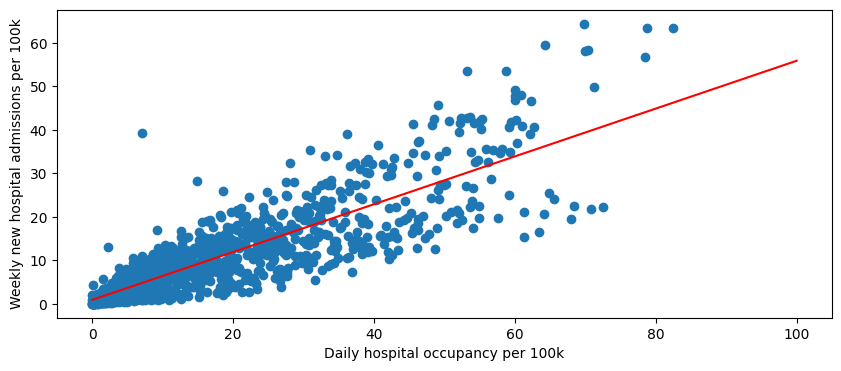

In [463]:
x = []
y = []

data = {}

# Store all Daily occupancy per 100k with country and time
for line in df_hosp_daily.iterrows():
    key = str(line[1]['Time'])+line[1]['Country']
    data[key] = line[1]['Daily hospital occupancy per 100k']

# Find matching time/country, and map weekly with daily 
for line in df_hosp_weekly.iterrows():
    key = str(line[1]['Time'])+line[1]['Country']
    daily = data.get(key)
    if daily != None:
        weekly = line[1]['Weekly new hospital admissions per 100k']
        x.append(daily)
        y.append(weekly)

# Linear regression
data_linreg = np.polyfit(x,y,1)
x2 = np.linspace(0, 100, 10)
y2 = np.polyval(data_linreg, x2)

# Statistics for linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("R2 value =", r_value**2)

print(f'Weekly = {data_linreg[0].round(3)}*daily + {data_linreg[1].round(3)}')

# Scatter plot and regression line
fig = mpl.figure(figsize=(10, 4))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.set_xlabel('Daily hospital occupancy per 100k')
ax.set_ylabel('Weekly new hospital admissions per 100k')
ax.plot(x2,y2,color='red')
mpl.show()


Four countries has data on Daily hospital occupancy, but lacks the data on Weekly admissions per 100k. We use the above result to estimate Weekly admissions per 100k for these countries.

In [464]:
A = 0.55
B = 0.884

# Function based on results above
def get_weekly(daily):
    return A*daily+B

Country_data = []
Time_data = []
Weekly_data = []

dates = pd.date_range(start=pd.to_datetime('2020-04-01'), end=pd.to_datetime('2023-04-19'), freq='1w')

# For Austria, Bulgaria, Lithuania and Romania, Weekly new hospital admissions per 100k is estimated
for c in name_dict.items():
    country = c[1]
    if country not in df_hosp_daily['Country'].values:
        continue
    if country not in df_hosp_weekly['Country'].values:
        df_country = df_hosp_daily[df_hosp_daily['Country'] == country]
        for date in dates:
            row = df_country.loc[df_country['Time'] == date]
            if len(row) == 0:
                continue
            value = row.iloc[0]['Daily hospital occupancy per 100k']

            Country_data.append(country)
            Time_data.append(date)
            Weekly_data.append(get_weekly(value))

df = pd.DataFrame({'Country': Country_data,'Time': Time_data,'Weekly new hospital admissions per 100k': Weekly_data})

# Add new data to df_hosp_weekly
df_hosp_weekly = pd.concat([df, df_hosp_weekly], ignore_index=True)

# Sort by Country name and Time
df_hosp_weekly = df_hosp_weekly.sort_values(by=['Country', 'Time']).reset_index(drop=True)

### Part 1

***
#### 1.
Since 2020 till 2022, which top 10 countries reported the most number of cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find these numbers relatively high compared to the country’s population? Do you see any connection among these countries regarding their geographical locations and the period in which most cases are observed? Discuss your observations.

In [465]:
df = df_daily.copy()
df.set_index('Time', inplace=True)

# Divide into quarters
quarters = df.resample('QE')

styled_dfs = [] # Store tables
quarterly_dfs = {}

# Calculate totalt deaths per quarter for each country
for name, quarter_df in quarters:
    # Sum up deaths for each country every quarter of a year, sort based on most deaths
    group = quarter_df.groupby('Country')['Cases'].sum().reset_index()
    group = group.sort_values('Cases', ascending=False).reset_index(drop=True)
    group.index += 1
    
    # Retrieve population data, calculate deaths per million inhabitants
    group['Population'] = group['Country'].map(pop_dict)
    group['Cpm'] = (group['Cases']/(group['Population']/1000000)).round(2)
    group.drop(['Population'], axis=1, inplace=True)
    
    # Add top10 to output list
    styled_dfs.append(group.head(10).style.format(precision=0).format_index(str.upper, axis=1))

# Format output, 4 tables in width
html_output = "<div style='display: flex; flex-wrap: wrap;'>"
for i, styled_df in enumerate(styled_dfs):
    if i%4 == 0: # Year header
        html_output += "<h2>202"+str(i//4)+"</h2></div><div style='display: flex; flex-wrap: wrap;'>"
    html_output += "<div style='width: 26%; padding: 10px;'> Q"+str((i)%4+1)+styled_df.to_html()+"</div>" # Table
    if (i+1) % 2 == 0: # New row
        html_output += "</div><div style='display: flex; flex-wrap: wrap;'>" 
html_output += "</div>"
display_html(html_output,raw=True)

# Times = ['2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4', '2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4']
# # Save as LaTeX tables
# for i, df in enumerate(styled_dfs):
#     latex_table = df.to_latex(caption=Times[i])
#     latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
#     print(latex_table)


,COUNTRY,CASES,CPM
1,Spain,167645,3542
2,Italy,105792,1774
3,Germany,74061,891
4,France,52128,774
5,Belgium,16977,1473
6,Netherlands,12449,715
7,Austria,7312,821
8,Portugal,7251,704
9,Norway,5107,951
10,Sweden,4834,468


***
#### 2.
Visualize each country’s total number of cases and deaths on a map plot using their geographical locations in 2020, 2021, and 2022. Discuss your observations.

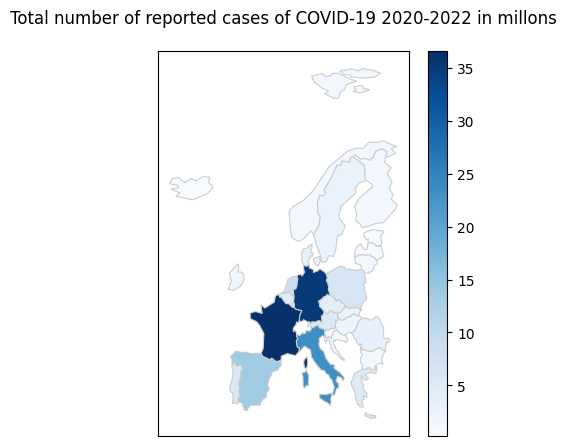

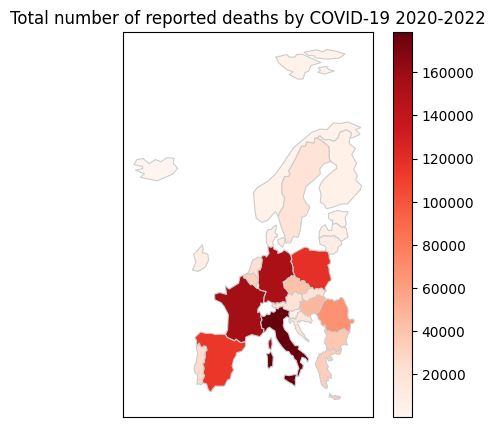

In [466]:
# Create dataframes that sums all deaths and cases
df_deaths = df_daily.groupby('Country')['Deaths'].sum().reset_index()

df_cases = df_daily.groupby('Country')['Cases'].sum().reset_index()
df_cases['Million Cases'] = df_cases['Cases']/1000000

# Load European map data from geopandas datasets
europe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = europe[europe['continent'] == 'Europe']

# Code to remove a french territory far away from europe
coordinates = ""
start = False
for char in str(europe.iat[2,5]):
    if char == ")":
        break
    if char == "-":
        start = True
    if start:
        coordinates += char

coordinates = [tuple(map(float, coord.split(' '))) for coord in coordinates.split(', ')]
coordinates = Polygon(coordinates)
europe.iat[2, 5] = europe.iat[2, 5].difference(coordinates)

# Merge dataframes with the European map based on the 'country' column
cases_map = europe.merge(df_cases, left_on='name', right_on='Country')
deaths_map = europe.merge(df_deaths, left_on='name', right_on='Country')

# Plotting the merged data, coloring countries based on cases or deaths
fig_c = mpl.figure(figsize=(5, 5))
ax_c = fig_c.add_subplot()
ax_c.set_xticks([])
ax_c.set_yticks([])
mpl.title('Total number of reported cases of COVID-19 2020-2022 in millons', pad=20)
cases_map.plot(column='Million Cases', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax_c)

fig_d = mpl.figure(figsize=(5, 5))
ax_d = fig_d.add_subplot()
ax_d.set_xticks([])
ax_d.set_yticks([])
mpl.title('Total number of reported deaths by COVID-19 2020-2022')
deaths_map.plot(column='Deaths', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax_d)
mpl.show()

***
#### 3.
What are the top 3 popular vaccine brands that have been used across the EU/EEA? Can you observe the same popularity at the country level? Are there any exceptions?

In [467]:
# Create dataframe with summed up NumberDosesReceived for each vaccine
df_vaccines = df_vaccination.groupby('Vaccine')['TotalDoses'].sum().reset_index()
df_all_doses = df_vaccines.sort_values(by='TotalDoses', ascending=False)

# Top 3 (without "unknown")
df_top3 = df_all_doses.drop(16).head(3).reset_index(drop=True)
df_top3.reset_index().drop(columns='index', axis=1)
df_top3.index += 1

# Top 3 for each country
df_no_unk = df_vaccination.copy()
df_no_unk = df_no_unk[df_no_unk['Vaccine'] != 'UNK']
df_countries = df_no_unk.groupby(['Country', 'Vaccine'])['TotalDoses'].sum().reset_index()

# Apply lambda-function to each group and concatenate the results
df_countries = df_countries.groupby('Country')
df_countries = df_countries.apply(lambda x: x.nlargest(3, 'TotalDoses')).reset_index(drop=True)
df_countries = df_countries[['Country', 'Vaccine']]
df_countries = df_countries.groupby('Country')['Vaccine'].agg(list)

# Convert the list of vaccines into separate columns (Top 1, Top 2, Top 3)
df_countries = pd.DataFrame(df_countries.tolist(), index=df_countries.index, columns=['Top 1', 'Top 2', 'Top 3'])

# Reset index, Add Germany, sort
df_countries.reset_index(inplace=True)
new_row = {'Country': 'Germany', 'Top 1': '-', 'Top 2': '-', 'Top 3': '-'}
df_countries.loc[len(df)] = new_row
df_countries = df_countries.sort_values(by='Country', ascending=True)

display(df_top3)
display(df_countries.style.hide())

# Save as LaTeX tables
# latex_table = df_top3.to_latex(caption='Top 3 vaccine brands used in EU/EEA')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)
# latex_table = df_countries.style.hide().to_latex(caption='Top 3 vaccine brands used for each country')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

ValueError: too many values to unpack (expected 2)

***
#### 4.
Considering the previous question, which target groups mainly received these vaccine brands in each country?

In [ ]:
# Copy of dataframe
df_vaccines = df_vaccination.copy()

# Remove unwanted targetgroups and sum up doses
df_vaccines = df_vaccines[~df_vaccines['TargetGroup'].isin(['ALL','1_Age60+','1_Age<60'])]
df_vaccines = df_vaccines.groupby(['Country', 'Vaccine', 'TargetGroup'])['TotalDoses'].sum().reset_index()

# Filter out top 3 vaccines we got from the last question
top_3 = ['COM', 'MOD', 'AZ']
df_filtered = df_vaccines[df_vaccines['Vaccine'].isin(top_3)]
grouped = df_filtered.groupby(['Country', 'Vaccine'])

# Define a function to get the largest target group for each vaccine in each country
def get_largest_target_group(group):
    # Get the row with the maximum 'NumberDosesReceived'
    largest_row = group.loc[group['TotalDoses'].idxmax()]
    return largest_row

# Apply the function to each group and create a new DataFrame
largest_target_group_df = grouped.apply(get_largest_target_group)

# Reset the index to include 'ReportingCountry' and 'Vaccine' as columns
largest_target_group_df = largest_target_group_df.reset_index(drop=True)
largest_target_group_df = largest_target_group_df[largest_target_group_df['TotalDoses'] != 0]

# Create table with vaccine as columns
df = largest_target_group_df.pivot_table(index='Country', columns='Vaccine', values='TargetGroup', aggfunc='sum').reset_index()

data = {'Country':[], 'COM':[], 'MOD':[], 'AZ':[]}

# Rearrange the data, create new Dataframe, add missing countries (Germany and France)
for c in name_dict.values():
    data['Country'].append(c)
    slice = df[df['Country'] == c]
    if len(slice) == 0: # Countries with no data
        data['AZ'].append('-')
        data['COM'].append('-')
        data['MOD'].append('-')
    else:
        # Add TargetGroup data
        if c == 'Liechtenstein':
            data['AZ'].append('-') # Deals with NaN-value
        else:
            data['AZ'].append(slice.values[0][1])
        data['COM'].append(slice.values[0][2])
        data['MOD'].append(slice.values[0][3])

# FRANCE and GERMANY all vaccines are UNK
df = pd.DataFrame(data)
display(df.style.hide())

# Save as LaTeX tables
# latex_table = df.style.hide().to_latex(caption='Top 3 vaccine brands target groups')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# latex_table = latex_table.replace('_', '\\_')
# print(latex_table)

Country,COM,MOD,AZ
Austria,Age25_49,Age25_49,Age25_49
Belgium,Age25_49,Age25_49,Age50_59
Bulgaria,Age25_49,Age25_49,Age25_49
Croatia,Age25_49,Age25_49,Age70_79
Cyprus,Age25_49,Age25_49,Age25_49
Czechia,Age25_49,Age25_49,Age70_79
Denmark,Age25_49,Age25_49,HCW
Estonia,Age25_49,Age25_49,Age60_69
Finland,Age25_49,Age25_49,Age60_69
France,-,-,-


***
#### 5.
Which countries are the most skeptical towards the first dose of the COVID-19 vaccine? Do you think this matter had any impact on the hospitalization level?

In [ ]:
# Retrieve firstDose data for 18+ population
df_firstdose = df_vaccination[df_vaccination['TargetGroup']=='ALL']

# Create dataframe with summed up NumberDosesReceived for each vaccine
df_firstdose = df_firstdose.groupby('Country')['FirstDose'].sum().reset_index()
df_firstdose['Population'] = df_firstdose['Country'].map(pop_dict)

# Calculate skepticism as 1 - (FirstDose / Population)
df_firstdose['Skepticism'] = (1 - (df_firstdose['FirstDose'] / df_firstdose['Population'])).round(2)

# Create a new DataFrame with 'Country' and 'Skepticism' columns
df_skepticism = df_firstdose[['Country', 'FirstDose', 'Population', 'Skepticism']]

# Rename the 'ReportingCountry' column to 'Country' for consistency
df_skepticism = df_skepticism.sort_values(by='Skepticism', ascending=False).reset_index(drop=True)
df_skepticism.index += 1
df_skepticism['Skepticism'] = df_skepticism['Skepticism'].astype(str)

display(df_skepticism)

# Save as LaTeX tables
# latex_table = df_skepticism.to_latex(caption='Skepticism toward COVID-19-vaccine')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

,Country,FirstDose,Population,Skepticism
1,Bulgaria,2077742,6951482,0.7
2,Romania,7917501,19328838,0.59
3,Slovakia,2704559,5457873,0.5
4,Poland,20848103,37958138,0.45
5,Croatia,2282163,4058165,0.44
6,Slovenia,1180783,2095861,0.44
7,Estonia,796997,1328976,0.4
8,Hungary,5921482,9769526,0.39
9,Czechia,6551506,10693939,0.39
10,Liechtenstein,25061,38747,0.35


***
#### 6.
Rank all EU/EEA countries, based on their vaccinated population under age 18 for the first dose of the COVID-19 vaccine, which countries have the most and least vaccinated people under age 18 in regards to their total populations?

In [ ]:
# Groupby first dose
df6g = df_vaccination.groupby(['Country','TargetGroup'])['FirstDose'].sum().reset_index()
df6g = df6g.loc[df6g['TargetGroup'] == 'Age<18']

# Add Population data and country name
df6g['Population'] =df6g['Country'].map(pop_dict)

# Calculate percentage of total population
df6g['Proportion'] = (df6g['FirstDose']/df6g['Population']).round(3)

# Order columns
cols = ['Country','Population','FirstDose', 'Proportion']
df6g=df6g.reindex(columns=cols)

# Sort by perc
df6g = df6g.sort_values('Proportion', ascending=False).reset_index(drop=True)
df6g.index += 1
print('Highest amount first doses for under 18 populations with regards to total population')
display(df6g.head(5))
df6g = df6g.sort_values('Proportion', ascending=True).reset_index(drop=True)
df6g.index += 1
print('Least amount of first doses under 18 populations with regards to total population')
display(df6g.head(5))

# Sort
df6g = df6g.sort_values('FirstDose', ascending=False).reset_index(drop=True)
df6g.index += 1
print('Total first doses for under 18 populations')
display(df6g)

# Save as LaTeX tables
# df6g['Proportion'] = df6g['Proportion'].astype(str)
# latex_table = df6g.to_latex(caption='People under 18 who recieved the first dose of COVID-19 vaccination for each country')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

Highest amount first doses for under 18 populations with regards to total population


,Country,Population,FirstDose,Proportion
1,Iceland,364134,43091,0.118
2,Spain,47332614,4859297,0.103
3,Portugal,10295909,1003285,0.097
4,Finland,5525292,453284,0.082
5,Denmark,5822763,473881,0.081


Least amount of first doses under 18 populations with regards to total population


,Country,Population,FirstDose,Proportion
1,Bulgaria,6951482,28612,0.004
2,Croatia,4058165,35087,0.009
3,Romania,19328838,270224,0.014
4,Slovenia,2095861,43805,0.021
5,Slovakia,5457873,134575,0.025


Total first doses for under 18 populations


,Country,Population,FirstDose,Proportion
1,Spain,47332614,4859297,0.103
2,France,67320216,4608158,0.068
3,Germany,83166711,4563350,0.055
4,Italy,59641488,4332328,0.073
5,Poland,37958138,1784079,0.047
6,Portugal,10295909,1003285,0.097
7,Netherlands,17407585,895339,0.051
8,Belgium,11522440,861956,0.075
9,Austria,8901064,525642,0.059
10,Greece,10718565,483328,0.045


***
#### 7.
Which countries have the oldest vaccinated population for the **second** dose of the COVID-19 vaccine in regards to their total population?

In [ ]:
# Copy dataset, keep rows where age is 60+, groupby country and sum second dose
df7 = df_vaccination.copy()
df7 = df7.loc[df7['TargetGroup'] == '1_Age60+']
df7g = df7.groupby(['Country'])['SecondDose'].sum().reset_index()

# Add Population data and country name
df7g['Population'] =df7g['Country'].map(pop_dict)

# Calculate percentage of total population
df7g['Proportion'] = (df7g['SecondDose']/df7g['Population']).round(3)

# Sort
df7g = df7g.sort_values('Proportion',ascending=False).reset_index(drop=True)

# Display
df7g.index += 1
cols = ['Country','Population','SecondDose', 'Proportion']
df7g=df7g.reindex(columns=cols)
display(df7g)

# Save as LaTeX tables
# df7g['Proportion'] = df7g['Proportion'].astype(str)
# latex_table = df7g.to_latex(caption='60+ population vaccinated with a second dose of COVID-19 vaccine')
# latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[H] \scriptsize')
# print(latex_table)

,Country,Population,SecondDose,Proportion
1,Finland,5525292,1539025,0.279
2,Portugal,10295909,2850385,0.277
3,Italy,59641488,16207428,0.272
4,Germany,83166711,22007037,0.265
5,Denmark,5822763,1523615,0.262
6,Greece,10718565,2696484,0.252
7,Belgium,11522440,2840014,0.246
8,France,67320216,16532224,0.246
9,Spain,47332614,11572556,0.244
10,Malta,514564,124544,0.242


***
#### 8.
Which countries’ health care was most affected by the coronavirus pandemic in 2020 compared to others? How are these statistics in 2022?

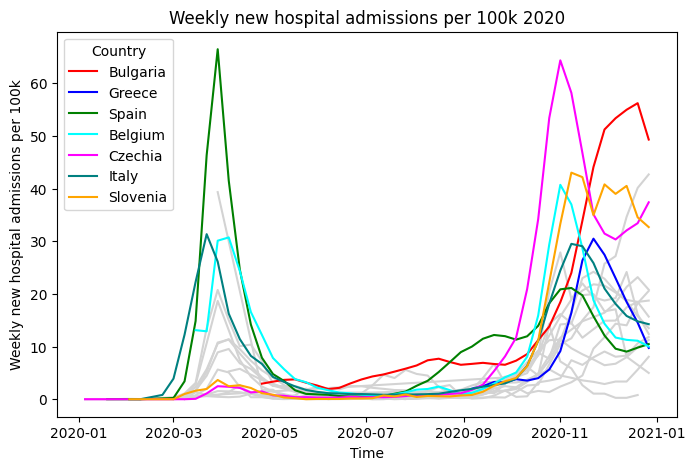

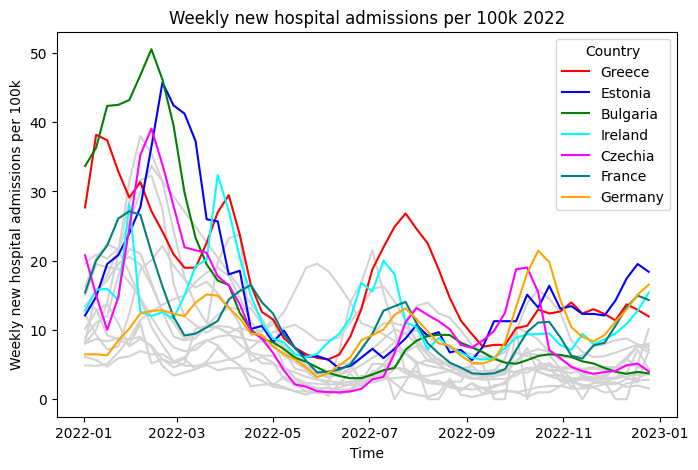

In [ ]:
COLORS = ('red', 'blue', 'green', 'cyan', 'magenta', 'teal', 'orange')

df = df_hosp_weekly.copy()
for year in (2020,2022):
    # Copy admission dateset where Daily hospital occupancy is the indicator
    dfw = df[df['Time'].dt.year == year].copy()

    # Calculate median and std, create table
    # 2020
    dfc = dfw.groupby('Country')['Weekly new hospital admissions per 100k'].agg(['mean','std']).reset_index()
    dfc = dfc.round({'mean': 1, 'std': 1})
    dfc = dfc.sort_values(by='mean', ascending=False).reset_index(drop=True)
    dfc = dfc.drop(0).reset_index(drop=True) # Remove Lithuania
    dfc.index += 1

    lst_country = dfc['Country'].tolist()

    # Create figure and colors
    fig = mpl.figure(figsize=(8, 5))
    ax = fig.add_subplot()
    colors = mpl.cm.tab20(np.linspace(0, 1, 25))

    # Create a line for each country
    for i in range(len(lst_country)-1, len(COLORS), -1):
        dfc = dfw[dfw['Country'] == lst_country[i]]
        mpl.plot(dfc['Time'], dfc['Weekly new hospital admissions per 100k'], color='lightgray')
        
    for i, country in enumerate(lst_country):
        dfc = dfw[dfw['Country'] == country]
        mpl.plot(dfc['Time'], dfc['Weekly new hospital admissions per 100k'], label=country, color=COLORS[i])
        if i == len(COLORS)-1:
            break
    
    # Add info to plot
    mpl.xlabel('Time')
    mpl.ylabel('Weekly new hospital admissions per 100k')
    mpl.legend(title='Country')
    mpl.title('Weekly new hospital admissions per 100k '+str(year))
    mpl.show()


***
#### 9.
Did the countries with high skepticism also have more people in the ICU per 100k?

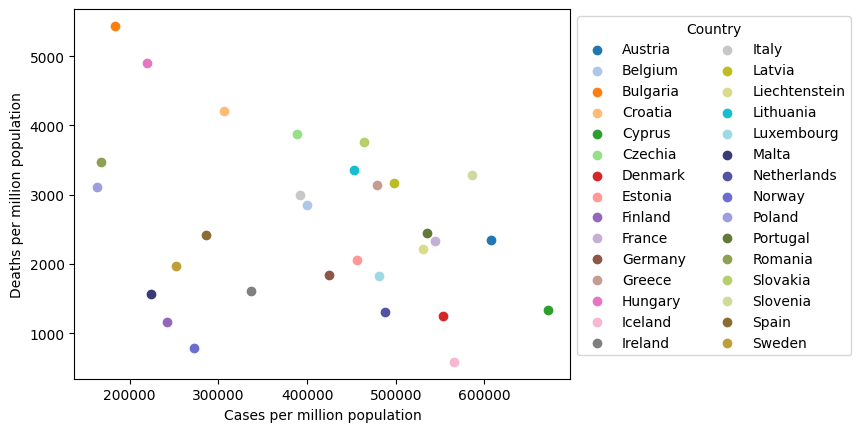

In [ ]:
#  Create dataframes that sums all deaths and cases
df_deaths = df_daily.groupby('Country')['Deaths'].sum().reset_index()
df_cases = df_daily.groupby('Country')['Cases'].sum().reset_index()
df_merged = pd.merge(df_cases, df_deaths, on='Country')

# Add population data, calculate daily admissions per million people
df_merged['Population'] = df_merged['Country'].map(pop_dict)

df_merged['Cases per million'] = df_merged['Cases']/(df_merged['Population']/1000000)
df_merged['Deaths per million'] = df_merged['Deaths']/(df_merged['Population']/1000000)

# 30 different colors
colors = sb.color_palette("tab20", 20) + sb.color_palette("tab20b", 10)

# Create a dot for each country
for i, country in enumerate(df_merged['Country'].unique()):
    country_c_d = df_merged[df_merged['Country'] == country]
    mpl.scatter(country_c_d['Cases per million'], country_c_d['Deaths per million'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Cases per million population')
mpl.ylabel('Deaths per million population')
mpl.legend(title='Country', bbox_to_anchor=(1, 1), ncol=2)
# mpl.title('Cases and Deaths per million population')
mpl.show()

#### 10.
COVID-19 lethality on a country level

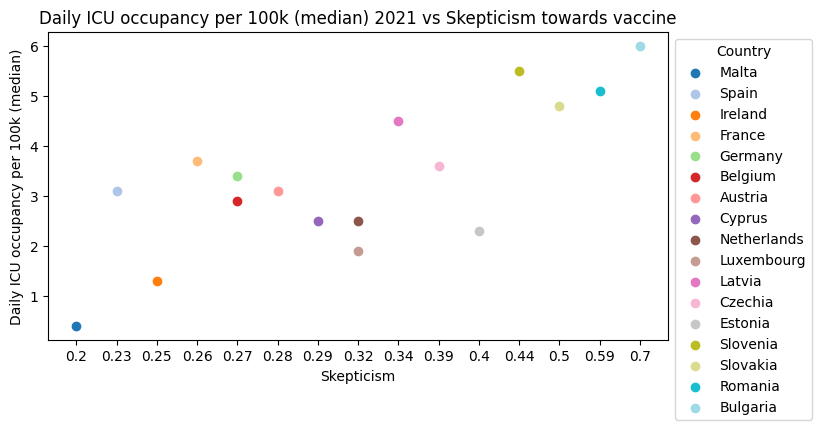

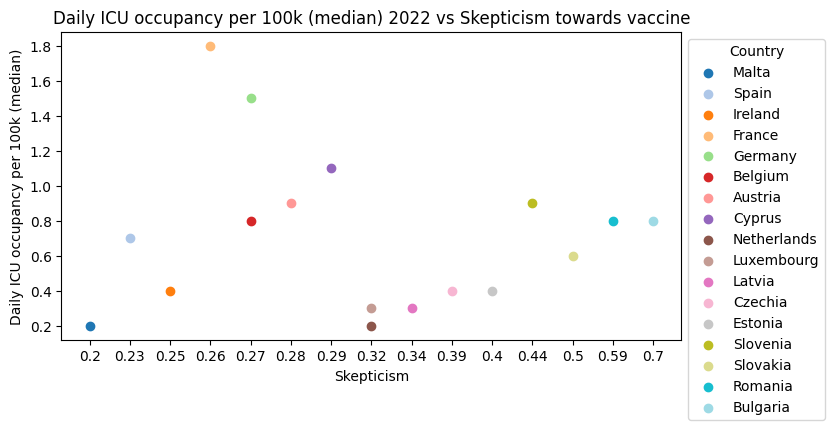

In [471]:
# Step 1: Copy skepticism data
df_skep = df_skepticism.copy().sort_values(by='Skepticism')
measure = 'median'

for year in (2021,2022):
    # Step 2: Process weekly ICU data for year
    df_year = df_icu_daily[df_icu_daily['Time'].dt.year == year].copy()

    dfc = df_year.groupby('Country')['Daily ICU occupancy per 100k'].agg([measure, 'std']).reset_index().round({measure: 1, 'std': 1}).sort_values(by=measure, ascending=False).reset_index(drop=True)
    dfc.index += 1

    # Step 3: Merge datasets
    df_merged = pd.merge(df_skep, dfc, on='Country')

    # Step 4: Create plot
    fig, ax = mpl.subplots(figsize=(8, 4))
    colors = mpl.cm.tab20(np.linspace(0, 1, len(df_merged['Country'].unique())))

    for i, country in enumerate(df_merged['Country'].unique()):
        country_data_2020 = df_merged[df_merged['Country'] == country]
        ax.scatter(country_data_2020['Skepticism'], country_data_2020[measure], label=country, color=colors[i])

    # Add plot details
    ax.set_xlabel('Skepticism')
    ax.set_ylabel('Daily ICU occupancy per 100k ('+measure+')')
    ax.legend(title='Country', bbox_to_anchor=(1, 1))
    ax.set_title('Daily ICU occupancy per 100k ('+measure+') '+str(year) +' vs Skepticism towards vaccine')
    mpl.show()

#### 11.
Which countries were the fastest and slowest at vaccinating their population with the first dose?

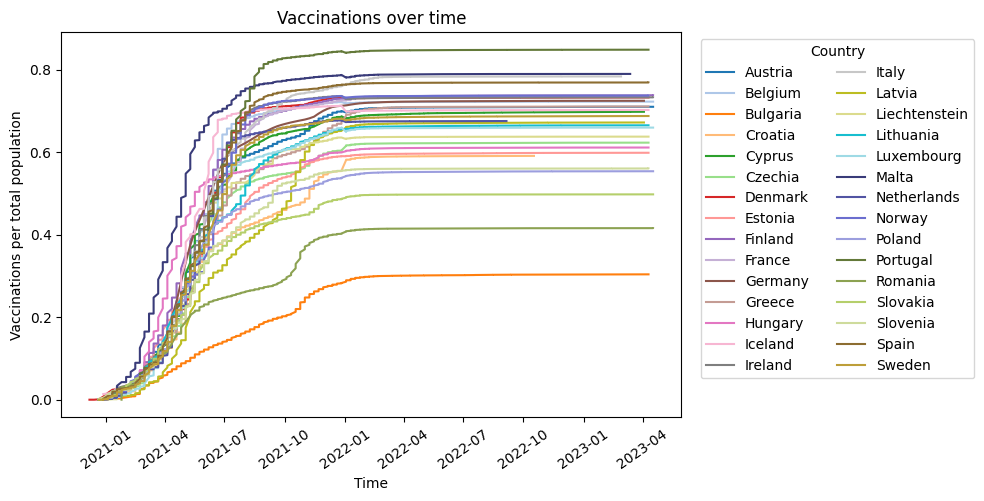

In [ ]:
# Copy wanted columns from the vaccinations dataset and use TargetGroup 'ALL'
df_vacc = df_vaccination[['Time', 'Country', 'FirstDose', 'Population', 'TargetGroup']].copy()
df_vacc = df_vacc[df_vacc['TargetGroup'] == 'ALL']

# Add cumsum column and cumsum per total population column
df_vacc['cumSum'] = df_vacc.groupby('Country')['FirstDose'].cumsum()
df_vacc['cumSum_pp'] = df_vacc['cumSum'] / (df_vacc['Population'])

# Create figure and colors
fig = mpl.figure(figsize=(8, 5))
ax = fig.add_subplot()

# 30 different colors
colors = sb.color_palette("tab20", 20) + sb.color_palette("tab20b", 10)

# Create a line for each country
for i, country in enumerate(df_vacc['Country'].unique()):
    country_data = df_vacc[df_vacc['Country'] == country]
    mpl.plot(country_data['Time'], country_data['cumSum_pp'], label=country, color=colors[i])

# Add info to plot
mpl.xlabel('Time')
mpl.ylabel('Vaccinations per total population')
mpl.legend(title='Country', bbox_to_anchor=(1.02, 1), ncol=2)
mpl.xticks(rotation=35)
mpl.title('Vaccinations over time')
mpl.show()